# Proejct 4: Web Scraping Job Posting
Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:


1. **Determine the industry factors that are most important in predicting the salary amounts for these data.**
2. **Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?**

To limit the scope, your principal has suggested that you focus on data-related job postings, e.g. **data scientist, data analyst, research scientist, business intelligence**, and any others you might think of. You may also want to decrease the scope by limiting your search to a **single region**.

Hint: Aggregators like [Indeed.com](https://www.indeed.com.sg/?r=us) regularly pool job postings from a variety of markets and industries.

Goal: Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

## Scraping data from Indeed
Example website screencapture:
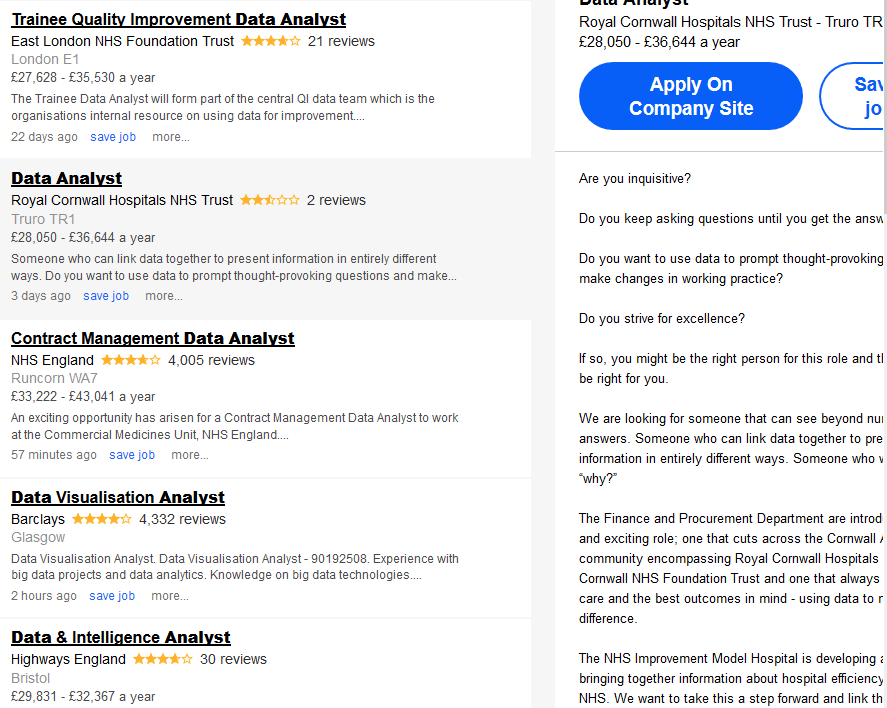

References:<br>
[Web Scraping Indeed for Key Data Science Job Skills - Jesse Steinweg-Woods](https://jessesw.com/Data-Science-Skills/) <br>
[Web Scraping Indeed.com to Predict Salaries - Nathan Mitchell](https://ntmitchell.github.io/indeed-jobs-postings/) <br>
https://bigdata-madesimple.com/top-big-data-tools-used-to-store-and-analyse-data/

The scraping process mainly deal with the main search page, and the long process make it extremely difficult to access individual job posting. There also a challenge that the website access is not stable,make iterating very difficult.This error often poped up with no reason. Thus, individual search keywords were used.
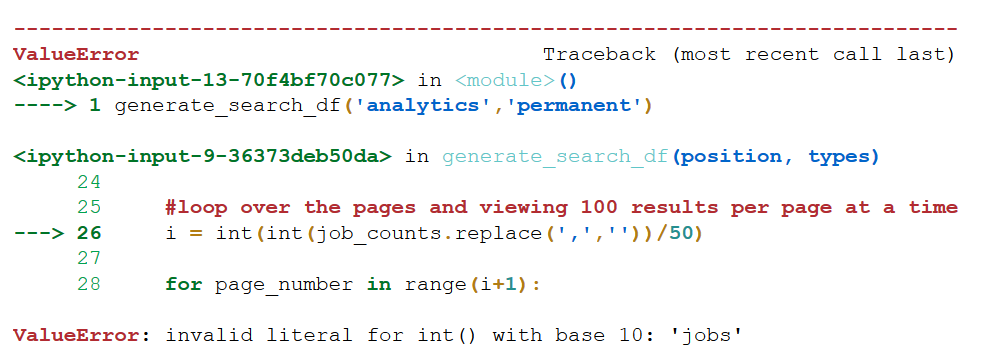

In [1]:
#web scraping
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import requests

import re

import pandas as pd
import numpy as np

In [2]:
# #key words
# #job title keywords
# job_title=['data scientist', 'data analyst', 'data engineer','research scientist', 'business intelligence','analytics']

# #job types
# job_type=['permanent','fulltime','contract','temporary','internship','parttime','apprenticeship']

First look at the 1st page of the search results by searching data analyst in UK, with 50 results display per page: <br>
https://www.indeed.co.uk/jobs?q=data+analyst&jt=permanent&limit=50<br> and open web development tool to inspect the webpage. <br>
It seems that the Indeed UK webiste can only allow maximum to display 50 search result at one page, further increase of the number after limit does not actually increase the display results. <br>

*The main focus* is on two job types: permanent and fulltime, as well as 6 positions: 'data scientist', 'data analyst', 'data engineer','research scientist', 'business intelligence','analytics



In [3]:
#test the function above 
#url: https://www.indeed.com/viewjob?jk=27162dddbf2459fa&from=serp&vjs=3
#website_cleaner('https://www.indeed.com/viewjob?jk=27162dddbf2459fa&from=serp&vjs=3')

In [9]:
#Start web scraping
#The main purpose is to extract as much as information as possible
#yet keep the information succinct 

def generate_search_df(position,types):

    result_df=pd.DataFrame()
    
    print ('Searching for ',position,'and','types')
    
    title='+'.join(position.split(' '))
    
    
    #initiate an empty list to collect data everytime for new position and job type
    result_list=[]

    print ('Under ',position,'search for ',types,' job')

    url='https://www.indeed.co.uk/jobs?q={}&jt={}&limit=50'.format(title,types)
    response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})
    first_page=BeautifulSoup(response.content,'html.parser')

    job_counts=(first_page.find("div", attrs = {"id": "searchCount"}).text.split(' '))[-1]

    #loop over the pages and viewing 100 results per page at a time
    i = int(int(job_counts.replace(',',''))/50)

    for page_number in range(i+1):
        print ('Accessing page ',page_number,'\n')

        url_each_page = 'https://www.indeed.co.uk/jobs?q={}&jt={}&limit=50&start={}'.format(position,types,(str(50*page_number)))
        response = requests.get(url_each_page,headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})
        soup_each_page = BeautifulSoup(response.content,'html.parser')
        # Get all advertised job descriptions
        results = soup_each_page.find_all('div', attrs={'data-tn-component': 'organicJob'})

        #extract job ID for each job listing
        for x in results:
            job_id = x.find(name='h2', attrs={"class": "jobtitle"})['id']
            job_title = x.find('a', attrs={'data-tn-element': "jobTitle"})
            job_link = "https://www.indeed.com" + x.find('h2', attrs={"class": "jobtitle"}).find('a')['href']
            job_summary=x.find('span',{'class':'summary'})
            company=x.find(name='span', attrs={'class':'company'})
            location = x.find(name='span', attrs={'class':'location'})
            time_posted = x.find('span',{'class':'date'})
            salary = x.find(name='span', attrs={'class':'no-wrap'})


            #set default missing values
            if job_title != None:
                job_title_result = job_title.get_text().strip()
            else:
                job_title_result = np.nan

            if company != None:
                company_result = company.get_text().strip()
            else:
                company_result = np.nan

            if job_summary != None:
                job_summary_result = job_summary.get_text().strip()
            else:
                job_summary_result = np.nan

            if salary != None:
                salary_result = salary.get_text().strip()
            else:
                salary_result = np.nan

            if location != None:
                location_result = location.get_text().strip()
            else:
                location_result = np.nan

            if time_posted != None:
                time_posted_result = time_posted.get_text().strip()
            else:
                time_posted_result=np.nan

            for div in x.find_all(name='td',attrs={"class":"snip"}):
                try:
                    span = div.find(name="span", attrs={"class":"no-wrap"})
                    salary_result = span.get_text().strip()
                except:
                    salary_result = np.nan

            review = x.find('a', attrs={"class": "ratingsLabel"})
            if review != None:
                review_result = review.get_text().strip()
            else:
                review_result=np.nan


            result_list.append([job_id,types, title,time_posted_result, job_title_result, company_result, salary_result, 
                                location_result, review_result,
                                job_summary_result])
        result_df=result_df.append(result_list)
    result_df.drop_duplicates(inplace=True)
        
    result_df.columns = ['job_id','job_types','job_tag','post_time', 'job_title', 'company', 'salary', 
                                    'location', 'no_of_review','job_summary']
    
    #save list into csv file

    print ('It\'s done now! You can look at the output csv file.')
    print ('There are ',len(result_df),'jobs successfully extracted. ')
    result_df.to_csv('./{}.csv'.format(position + types))

    return result_df.head(2)



In [6]:
generate_search_df('data scientist','permanent')

Searching for  data scientist and types
Under  data scientist search for  permanent  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

It's done now! You can look at the output csv file.
There are  944 jobs successfully extracted. 


job_id  job_types         job_tag     post_time  \
0    jl_3becc778f10b2727  permanent  data+scientist   3 hours ago   
1    jl_311f8c87f377fec1  permanent  data+scientist    9 days ago   
2    jl_950a6428afc8792c  permanent  data+scientist   10 days ago   
3    jl_8e7a2074815a0521  permanent  data+scientist    2 days ago   
4    jl_a48d2101a8c79123  permanent  data+scientist    8 days ago   
5    jl_2ef1238fcfa3f7ef  permanent  data+scientist   14 days ago   
6    jl_1c2067a43b42f93c  permanent  data+scientist    2 days ago   
7    jl_6ef0e4669d224598  permanent  data+scientist    3 days ago   
8    jl_4eb6eb7f377b9215  permanent  data+scientist  30+ days ago   
9    jl_d69e84de1f1c38fc  permanent  data+scientist  30+ days ago   
10   jl_f4b4fb6f85f5c519  permanent  data+scientist    8 days ago   
11   jl_1e7d752f9231c7f9  permanent  data+scientist     1 day ago   
12   jl_6aef216dbb75776d  permanent  data+scientist   16 days ago   
13   jl_6912f8d657169a34  permanent  data+scientist  30+ days ago   
14   jl_29d52f6b044e5bf9  permanent  data+scientist   25 days ago   
15   jl_c8be98b859aaed20  permanent  data+scientist    6 days ago   
16   jl_b694f4948b41a528  permanent  data+scientist    6 days ago   
17   jl_1c337ac04e47d601  permanent  data+scientist     1 day ago   
18   jl_a31294ccedf055c5  permanent  data+scientist   17 days ago   
19   jl_7a5db9110ac22d0d  permanent  data+scientist    3 days ago   
20   jl_377077675a7a517d  permanent  data+scientist   20 days ago   
21   jl_024fc44d326557b3  permanent  data+scientist    5 days ago   
22   jl_b5e23e2dc95774e9  permanent  data+scientist  30+ days ago   
23   jl_c2311a9dc4f70eea  permanent  data+scientist    3 days ago   
24   jl_cb55bff1bd0c73d5  permanent  data+scientist  22 hours ago   
25   jl_a1298842fb6428e3  permanent  data+scientist  30+ days ago   
26   jl_0fd84d77c4845eb4  permanent  data+scientist   27 days ago   
27   jl_ddce70d6e7ba2b7c  permanent  data+scientist  23 hours ago   
28   jl_a1cee8bad2e3528a  permanent  data+scientist   12 days ago   
29   jl_e646ba9167b4c128  permanent  data+scientist   14 days ago   
..                   ...        ...             ...           ...   
914  jl_d0667423ec0f2a8d  permanent  data+scientist   23 days ago   
915  jl_bbdc360aae9ef10b  permanent  data+scientist   14 days ago   
916  jl_d1c76369b3c39423  permanent  data+scientist   13 days ago   
917  jl_d73e9872d0a83cfe  permanent  data+scientist    3 days ago   
918  jl_6208c05ffba2bbfb  permanent  data+scientist   20 days ago   
919  jl_dbb886a212407b9b  permanent  data+scientist  30+ days ago   
920  jl_d9e11a286c0bd0f8  permanent  data+scientist    9 days ago   
921  jl_5c18559410a3588a  permanent  data+scientist    3 days ago   
922  jl_925137fa02ca4428  permanent  data+scientist  30+ days ago   
923  jl_ddb5bf0824275b69  permanent  data+scientist  30+ days ago   
924  jl_90726cb9333f69c7  permanent  data+scientist  30+ days ago   
925  jl_72c3539d35c954ed  permanent  data+scientist  30+ days ago   
926  jl_33034e2e0c6d9e56  permanent  data+scientist  30+ days ago   
927  jl_507b9bdbd0b732ce  permanent  data+scientist   23 days ago   
928  jl_6f960756171c948d  permanent  data+scientist  30+ days ago   
929  jl_6867261c3dd1acf0  permanent  data+scientist  30+ days ago   
930  jl_4ee65ad33f4bc44c  permanent  data+scientist    2 days ago   
931  jl_5df29c583944d45c  permanent  data+scientist  30+ days ago   
932  jl_26c324ea4e4eff43  permanent  data+scientist    2 days ago   
933  jl_ff9765b28a9b58fe  permanent  data+scientist    9 days ago   
934  jl_e0ebb8f8566e2165  permanent  data+scientist  30+ days ago   
935  jl_b6476f840d60301b  permanent  data+scientist   24 days ago   
936  jl_e4b84149d76f1add  permanent  data+scientist    8 days ago   
937  jl_b04b7f77d1ed71a5  permanent  data+scientist   10 days ago   
938  jl_223d61d53612ebab  permanent  data+scientist   28 days ago   
939  jl_79797981c430ece3  permanent  data+scientist   13 days ago   
940  jl_c1ac9008

In [7]:
generate_search_df('data analyst','permanent')

Searching for  data analyst and types
Under  data analyst search for  permanent  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Accessing page  43 

A

job_id  job_types       job_tag     post_time  \
0     jl_d8844c8a0c78b2ef  permanent  data+analyst   2 hours ago   
1     jl_5c9490b54fdb4072  permanent  data+analyst   3 hours ago   
2     jl_650cff5dfb789610  permanent  data+analyst   9 hours ago   
3     jl_02c8bfacb7b2d1cb  permanent  data+analyst    2 days ago   
4     jl_6b8942012bd01c63  permanent  data+analyst    2 days ago   
5     jl_c2f2e1627367aad3  permanent  data+analyst  30+ days ago   
6     jl_8639d5233cedec6a  permanent  data+analyst     1 day ago   
7     jl_0c018b18cc1f4426  permanent  data+analyst     1 day ago   
8     jl_2a2d280e3bb6893e  permanent  data+analyst    8 days ago   
9     jl_95469b8d44cf0d18  permanent  data+analyst    2 days ago   
10    jl_4022dd18dae161b7  permanent  data+analyst   20 days ago   
11    jl_fd341e5d13b24a0e  permanent  data+analyst     1 day ago   
12    jl_0f04a6633858db05  permanent  data+analyst    7 days ago   
13    jl_1dd9d5871fee5770  permanent  data+analyst   3 hours ago   
14    jl_708f838c76153238  permanent  data+analyst    6 days ago   
15    jl_109395a747101130  permanent  data+analyst   13 days ago   
16    jl_d0ca41023a81d735  permanent  data+analyst   14 days ago   
17    jl_f8cd9f9111f3fe01  permanent  data+analyst    9 days ago   
18    jl_fee61f5e016415e9  permanent  data+analyst   20 days ago   
19    jl_fbc9c6385234ae43  permanent  data+analyst    9 days ago   
20    jl_c690886c9a7af780  permanent  data+analyst  30+ days ago   
21    jl_8e6b1b7a40b041d0  permanent  data+analyst  11 hours ago   
22    jl_54232a4a90cea297  permanent  data+analyst  30+ days ago   
23    jl_f0b045e86454ffa1  permanent  data+analyst     1 day ago   
24    jl_c0de6f80a8505f8b  permanent  data+analyst  22 hours ago   
25    jl_6aef216dbb75776d  permanent  data+analyst   16 days ago   
26    jl_634716bfb9701d17  permanent  data+analyst    6 days ago   
27    jl_a4db1c2c23a2068e  permanent  data+analyst    2 days ago   
28    jl_f5aad32ac1a1a67e  permanent  data+analyst  30+ days ago   
29    jl_0b7f1bfaafc567af  permanent  data+analyst    9 days ago   
...                   ...        ...           ...           ...   
998   jl_1b45cbb88917108d  permanent  data+analyst   19 days ago   
999   jl_8db713575787e7a8  permanent  data+analyst  30+ days ago   
3300  jl_eb2e248367fd0fef  permanent  data+analyst   14 days ago   
3302  jl_a83b9f2dd69d4d01  permanent  data+analyst    6 days ago   
3303  jl_227a8ac6c91f758c  permanent  data+analyst   26 days ago   
3304  jl_bddfdccc82dc2381  permanent  data+analyst    6 days ago   
3307  jl_c70042079d6b28da  permanent  data+analyst    7 days ago   
3311  jl_50386c32b1e06847  permanent  data+analyst   9 hours ago   
3312  jl_6ecb87a7c21bbebe  permanent  data+analyst  30+ days ago   
3313  jl_9577f0dccc6a40cb  permanent  data+analyst  30+ days ago   
3314  jl_a8bb0694f4a3c165  permanent  data+analyst  30+ days ago   
3316  jl_d493a148f820c722  permanent  data+analyst  30+ days ago   
3317  jl_2a096e76fdeca014  permanent  data+analyst   14 days ago   
3318  jl_b74c311c3d64741d  permanent  data+analyst  30+ days ago   
3319  jl_d0474ac52d32e62f  permanent  data+analyst   10 days ago   
3320  jl_8c4cfd0c3154b9eb  permanent  data+analyst   23 days ago   
3323  jl_557b617042824aa7  permanent  data+analyst  30+ days ago   
3324  jl_1dc532198171d98f  permanent  data+analyst   19 days ago   
3326  jl_4be10b062e2228b2  permanent  data+analyst    7 days ago   
3330  jl_371dc2e042b1f410  permanent  data+analyst   7 hours ago   
3331  jl_8fa1da0872665140  permanent  data+analyst    3 days ago   
3333  jl_2dbf73d493630661  permanent  data+analyst  30+ days ago   
3335  jl_62d13a7d744ed1e2  permanent  data+analyst   14 days ago   
3337  jl_38fd94af2830acf5  permanent  data+analyst  30+ days ago   
3338  jl_7ead85c614a6de4d  permanent  data+analyst  30+ days ago   
3339  jl_23e5ecdcca5749c0  permanent  data+analyst  30+ days ago   
3342  jl_117aa5ba60695276  permanent  data+analyst  30+ days ago   
3348  j

In [8]:
generate_search_df('data engineer','permanent')

Searching for  data engineer and types
Under  data engineer search for  permanent  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Accessing page  43 


job_id  job_types        job_tag     post_time  \
0     jl_0c101a183a2bb72e  permanent  data+engineer    8 days ago   
1     jl_1b6051b03b8d9c83  permanent  data+engineer   23 days ago   
2     jl_55fc29e7d7c20bac  permanent  data+engineer  22 hours ago   
3     jl_5687f2b75f153096  permanent  data+engineer    2 days ago   
4     jl_294d237b64fe6c8a  permanent  data+engineer    2 days ago   
5     jl_24eef8c5def82a90  permanent  data+engineer  30+ days ago   
6     jl_4e21ef92dcd89d02  permanent  data+engineer  30+ days ago   
7     jl_740e28bccb2d441d  permanent  data+engineer    2 days ago   
8     jl_3c3d8949a3f66650  permanent  data+engineer    2 days ago   
9     jl_7bf59c332838f0b9  permanent  data+engineer    6 days ago   
10    jl_662365212ba71b70  permanent  data+engineer  30+ days ago   
11    jl_d4dd4d577cae1d69  permanent  data+engineer  30+ days ago   
12    jl_c1845e2eecc71cbb  permanent  data+engineer     1 day ago   
13    jl_3eb3fe3e4ec7eddd  permanent  data+engineer  30+ days ago   
14    jl_d1c15041d36c0dd4  permanent  data+engineer   23 days ago   
15    jl_23e7dee0c8775adb  permanent  data+engineer  30+ days ago   
16    jl_8b4f8ce71460352b  permanent  data+engineer  30+ days ago   
17    jl_1503b847031e6805  permanent  data+engineer    2 days ago   
18    jl_adb88a90eaafc8b2  permanent  data+engineer    6 days ago   
19    jl_27c147c6e5ec9799  permanent  data+engineer     1 day ago   
20    jl_2ed8638ae8f5b1be  permanent  data+engineer     1 day ago   
21    jl_1aba5c97bd13e96a  permanent  data+engineer  30+ days ago   
22    jl_42b859a55baea2c6  permanent  data+engineer    4 days ago   
23    jl_38c764822260cf38  permanent  data+engineer   30 days ago   
24    jl_e10ddfb2454f1215  permanent  data+engineer  30+ days ago   
25    jl_062ee504f1697a46  permanent  data+engineer  11 hours ago   
26    jl_337c16a3eda935bd  permanent  data+engineer     1 day ago   
27    jl_8ad86548c609c35f  permanent  data+engineer    7 days ago   
28    jl_95f1254e57c321a8  permanent  data+engineer    9 days ago   
29    jl_e068d67c77dc4aa7  permanent  data+engineer  30+ days ago   
...                   ...        ...            ...           ...   
1142  jl_94583ecf8cdf8766  permanent  data+engineer   12 days ago   
1143  jl_2e235e2444f1b0ed  permanent  data+engineer    2 days ago   
1144  jl_0084dceab1e8448d  permanent  data+engineer   10 days ago   
1146  jl_14b71e5fd6327519  permanent  data+engineer   14 days ago   
1147  jl_2e6daa8915ae9883  permanent  data+engineer   10 days ago   
1148  jl_67a0de1905ef29a4  permanent  data+engineer   13 days ago   
1901  jl_07e65eed1d45ca0e  permanent  data+engineer    6 days ago   
1906  jl_d789fec83907eb7a  permanent  data+engineer    6 days ago   
1909  jl_df96a50a7d79545a  permanent  data+engineer   19 days ago   
1910  jl_198373b957a5626a  permanent  data+engineer     1 day ago   
1913  jl_bfeac71a7abddfe9  permanent  data+engineer   26 days ago   
1919  jl_fb4dccf104d1e15d  permanent  data+engineer   16 days ago   
1922  jl_8664d342716d951e  permanent  data+engineer   13 days ago   
1925  jl_48b3ad5b192b1174  permanent  data+engineer   20 days ago   
1933  jl_4e365f854316a224  permanent  data+engineer   21 days ago   
1936  jl_d112b583c8fbac0e  permanent  data+engineer   20 days ago   
1938  jl_e9d070f6b8e33566  permanent  data+engineer   27 days ago   
1941  jl_a387c040cd45688c  permanent  data+engineer   27 days ago   
1945  jl_46a0252f141acc3f  permanent  data+engineer  30+ days ago   
1946  jl_04cd1fd680b60317  permanent  data+engineer    7 days ago   
1947  jl_907c4c17f3b71387  permanent  data+engineer   29 days ago   
3306  jl_d789fec83907eb7a  permanent  data+engineer    6 days ago   
3309  jl_df96a50a7d79545a  permanent  data+engineer   19 days ago   
3312  jl_c06ac1065d76211a  permanent  data+engineer   22 days ago   
3314  jl_adb67c96d6596a8c  permanent  data+engineer    2 days ago   
3319  jl_fb4dccf104d1e15d  permanent  data+engineer   16 days ago   
3333  jl_4e365f85

In [11]:
generate_search_df('research scientist','permanent')

Searching for  research scientist and types
Under  research scientist search for  permanent  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

It's done now! You can look at the output csv file.
There are  491 jobs successfully extracted. 


job_id  job_types             job_tag    post_time  \
0  jl_aa82ca0de298dbe6  permanent  research+scientist  22 days ago   
1  jl_7c6c809b5e0f60d9  permanent  research+scientist   8 days ago   

                      job_title                                    company  \
0  Explosive Research Scientist  Defence Science and Technology Laboratory   
1          Laboratory Scientist                              Anthony Nolan   

                     salary       location no_of_review  \
0  £31,500 - £35,500 a year  Salisbury SP4   17 reviews   
1            £25,000 a year         London    5 reviews   

                                         job_summary  
0   Delivering high quality research to meet oft...  
1  We are looking for a Laboratory Scientist to j...

In [12]:
generate_search_df('business intelligence','permanent')

Searching for  business intelligence and types
Under  business intelligence search for  permanent  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Acce

job_id  job_types                job_tag     post_time  \
0  jl_1c4bbb310c1865b4  permanent  business+intelligence  21 hours ago   
1  jl_8561f1b6cd4a665e  permanent  business+intelligence    6 days ago   

                         job_title         company          salary   location  \
0  Business Intelligence Developer           Codex  £35,000 a year  Hampshire   
1  Business Intelligence Developer  Joules Limited             NaN      Corby   

  no_of_review                                        job_summary  
0   10 reviews  Business Intelligence Developer (Qlikview) - L...  
1          NaN  Supporting the day to day running of Joules Bu...

In [15]:
generate_search_df('analytics','permanent')

Searching for  analytics and types
Under  analytics search for  permanent  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Accessing page  43 

Accessi

job_id  job_types    job_tag   post_time  \
0  jl_aefa77662d5bfc1d  permanent  analytics  6 days ago   
1  jl_b31a196a2fff5772  permanent  analytics   1 day ago   

                                           job_title     company salary  \
0               Head of Customer Insight & Analytics  Rank Group    NaN   
1  Advanced Analytics Consultant (Predictive, AI,...  Capita Plc    NaN   

     location   no_of_review  \
0  Maidenhead     18 reviews   
1   Edinburgh  2,017 reviews   

                                         job_summary  
0  � Responsible for leading a team of Analysts a...  
1  Become an Advanced Analytics Consultant with B...

In [17]:
generate_search_df('data scientist','fulltime')

Searching for  data scientist and types
Under  data scientist search for  fulltime  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

It's done now! You can look at the output csv file.
There are  1000 jobs successfully extracted. 


job_id job_types         job_tag    post_time  \
0  jl_6635075b094accda  fulltime  data+scientist    1 day ago   
1  jl_950a6428afc8792c  fulltime  data+scientist  10 days ago   

               job_title                         company          salary  \
0  Data Scientist Intern                        Illumina             NaN   
1         Data Scientist  Office for National Statistics  £35,200 a year   

       location no_of_review  \
0       England  144 reviews   
1  Newport NP10   43 reviews   

                                         job_summary  
0  Data Scientist Intern. Machine Learning on DNA...  
1  We are recruiting a Data Scientist to fill a v...

In [18]:
generate_search_df('data analyst','fulltime')

Searching for  data analyst and types
Under  data analyst search for  fulltime  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Accessing page  43 

Ac

job_id job_types       job_tag    post_time  \
0  jl_3b7d740f0102253d  fulltime  data+analyst  22 days ago   
1  jl_e35d91216e282815  fulltime  data+analyst   3 days ago   

                                  job_title  \
0  Trainee Quality Improvement Data Analyst   
1                              Data Analyst   

                              company                    salary   location  \
0    East London NHS Foundation Trust  £27,628 - £35,530 a year  London E1   
1  Royal Cornwall Hospitals NHS Trust  £28,050 - £36,644 a year  Truro TR1   

  no_of_review                                        job_summary  
0   21 reviews  The Trainee Data Analyst will form part of the...  
1    2 reviews  Someone who can link data together to present ...

In [22]:
generate_search_df('data engineer','fulltime')

Searching for  data engineer and types
Under  data engineer search for  fulltime  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Accessing page  43 



job_id job_types        job_tag    post_time  \
0  jl_64eaa46804364549  fulltime  data+engineer  11 days ago   
1  jl_7c235a26d266283a  fulltime  data+engineer   2 days ago   

                    job_title company salary   location   no_of_review  \
0  Graduate Big Data Engineer   Jagex    NaN  Cambridge      4 reviews   
1               Data Engineer     RBS    NaN  Edinburgh  2,920 reviews   

                                         job_summary  
0  As Graduate Big Data Engineer, you will:. Jage...  
1  As a data engineer, you'll be supporting data ...

In [24]:
generate_search_df('research scientist','fulltime')

Searching for  research scientist and types
Under  research scientist search for  fulltime  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

It's done now! You can look at the output csv file.
There are  1000 jobs successfully extracted. 


job_id job_types             job_tag   post_time  \
0  jl_a407a4dfaf332ef1  fulltime  research+scientist  5 days ago   
1  jl_bd0cfe61a897cc7e  fulltime  research+scientist  9 days ago   

                     job_title  \
0       R&D Research Scientist   
1  Research Vascular Scientist   

                                             company  \
0                                           ConvaTec   
1  Chelsea and Westminster Hospital NHS Foundatio...   

                     salary       location no_of_review  \
0                       NaN        Deeside  136 reviews   
1  £26,682 - £34,049 a year  Isleworth TW7   11 reviews   

                                         job_summary  
0  Proven research & development laboratory testi...  
1  Research Vascular Scientist, West Middlesex Lo...

In [25]:
generate_search_df('business intelligence','fulltime')

Searching for  business intelligence and types
Under  business intelligence search for  fulltime  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Acces

job_id job_types                job_tag   post_time  \
0  jl_a6aac63c6c160a07  fulltime  business+intelligence  3 days ago   
1  jl_5873a76350c2f1ef  fulltime  business+intelligence  7 days ago   

                          job_title  \
0  Business Intelligence Internship   
1     Business Intelligence Officer   

                                             company  \
0                                    Kapeinternships   
1  Central and North West London NHS Foundation T...   

                     salary    location no_of_review  \
0                       NaN      London          NaN   
1  £26,565 - £42,046 a year  London NW1   16 reviews   

                                         job_summary  
0  Distributing these templated Business Intellig...  
1  An exciting opportunity has arisen for a Busin...

In [28]:
generate_search_df('analytics','fulltime')

Searching for  analytics and types
Under  analytics search for  fulltime  job
Accessing page  0 

Accessing page  1 

Accessing page  2 

Accessing page  3 

Accessing page  4 

Accessing page  5 

Accessing page  6 

Accessing page  7 

Accessing page  8 

Accessing page  9 

Accessing page  10 

Accessing page  11 

Accessing page  12 

Accessing page  13 

Accessing page  14 

Accessing page  15 

Accessing page  16 

Accessing page  17 

Accessing page  18 

Accessing page  19 

Accessing page  20 

Accessing page  21 

Accessing page  22 

Accessing page  23 

Accessing page  24 

Accessing page  25 

Accessing page  26 

Accessing page  27 

Accessing page  28 

Accessing page  29 

Accessing page  30 

Accessing page  31 

Accessing page  32 

Accessing page  33 

Accessing page  34 

Accessing page  35 

Accessing page  36 

Accessing page  37 

Accessing page  38 

Accessing page  39 

Accessing page  40 

Accessing page  41 

Accessing page  42 

Accessing page  43 

Accessin

job_id job_types    job_tag   post_time  \
0  jl_aefa77662d5bfc1d  fulltime  analytics  6 days ago   
1  jl_719d91b70ae97f1c  fulltime  analytics   1 day ago   

                              job_title                              company  \
0  Head of Customer Insight & Analytics                           Rank Group   
1       Head of Performance & Analytics  Barnet Clinical Commissioning Group   

                     salary    location no_of_review  \
0                       NaN  Maidenhead   18 reviews   
1  £63,754 - £75,907 a year      Barnet          NaN   

                                         job_summary  
0  � Responsible for leading a team of Analysts a...  
1  Reporting to the Director of QIPP, Planning an...

In [32]:
import os

In [33]:
pwd

'C:\\Users\\zhixi\\Dropbox\\Postgraduate\\GA Data Immsersive\\Other jupyter notebook resources\\dsi-project-submission\\project-4_zhixin(jason)_wu'

In [40]:
df1=pd.read_csv('data/analyticsfulltime.csv')
df2=pd.read_csv('data/analyticspermanent.csv')

In [45]:
# test_df=pd.concat([df1,df2],ignore_index=False)
# test_df

In [46]:
# len(df1)

In [47]:
# len(df2)

In [48]:
# len(test_df)

In [49]:
df3=pd.read_csv('data/business intelligencefulltime.csv')
df4=pd.read_csv('data/business intelligencepermanent.csv')

In [50]:
df5=pd.read_csv('data/data analystfulltime.csv')
df6=pd.read_csv('data/data analystpermanent.csv')

In [51]:
df7=pd.read_csv('data/data engineerfulltime.csv')
df8=pd.read_csv('data/data engineerpermanent.csv')

In [52]:
df9=pd.read_csv('data/research scientistfulltime.csv')
df10=pd.read_csv('data/research scientistpermanent.csv')

In [53]:
final_df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10])

In [54]:
final_df.drop_duplicates(inplace=True)

In [59]:
final_df.to_csv('combined.csv')

In [57]:
final_df.head()

Unnamed: 0               job_id job_types    job_tag       post_time  \
0           0  jl_aefa77662d5bfc1d  fulltime  analytics      6 days ago   
1           1  jl_719d91b70ae97f1c  fulltime  analytics       1 day ago   
2           2  jl_d123655931ba246c  fulltime  analytics  43 minutes ago   
3           3  jl_72f97ac8201bc2a2  fulltime  analytics    30+ days ago   
4           4  jl_bbd4d855dae0fede  fulltime  analytics    19 hours ago   

                                           job_title  \
0               Head of Customer Insight & Analytics   
1                    Head of Performance & Analytics   
2  Insights & Analytics Intern | 8 week summer pl...   
3                            Intern (Data Analytics)   
4                           Data & Analytics Analyst   

                               company                    salary    location  \
0                           Rank Group                       NaN  Maidenhead   
1  Barnet Clinical Commissioning Group  £63,754 - £75,907 a year      Barnet   
2                             Asos.com                       NaN      London   
3                   Keppel Corporation                       NaN      Keppel   
4                                  RBS                       NaN     Belfast   

    no_of_review                                        job_summary  
0     18 reviews  � Responsible for leading a team of Analysts a...  
1            NaN  Reporting to the Director of QIPP, Planning an...  
2    233 reviews  Developing a great understanding of modern ana...  
3      3 reviews  Supports the Data Analytics team on project ba...  
4  2,920 reviews  Strong analytic and problem solving abilities....

In [58]:
len(final_df)

9742